# Aim of this document is to create a model of the FWt with Gravity acting as an external force and linerise the EoM about all ifxed points (across velocities)

In [25]:
import sympy as sym
import sympy.physics.mechanics as me
import pandas as pd
import seaborn as sns

import numpy as np
from scipy.integrate import odeint,LSODA,BDF,solve_ivp
import matplotlib.pyplot as plt

import sys, os

sys.path.insert(1, os.path.join(sys.path[0], '..\..'))
import sympyTransforms as symt
import custom_plot_objects as cpo
import FwtModels.dof2 as dof2
import FwtModels.AeroModels as ams

me.mechanics_printing()

### Define the problem

In [26]:
# define FWTD mass and mass ratio
FWTD_mass = 1
ratio = 4
inner_freq = 2


# create the variables
p = dof2.FwtParameters.Default2DoF() # parameter container

# set values for independent symbols
p.s.value = 1
p.c.value = 0.15
p.g.value = 9.81
p.rho.value = 1.225
p.a_t.value = 2 * np.pi
p.alpha_r.value = np.deg2rad(5)
p.Lambda.value = np.deg2rad(25)

p.m.value = FWTD_mass
p.sigma = dof2.FwtVariable(ratio,'sigma')   #mass ratio

# set expression for dependent symbols
p.k = (sym.Integer(inner_freq)*2*sym.pi)**2*(p.m*(p.sigma+sym.Integer(1)))
p.m_w = p.m*p.sigma
p.I_xx = sym.Rational(1,12)*p.m*p.s**2*1
p.l = p.s*sym.Rational(1,2)


p.g.value = 9.81*1
p.alpha_r.value == np.deg2rad(5)

# potential Energy
half = sym.Rational(1,2)
U = half*p.k*(p.q[1])**2

# Transforms for the mass
wing_frame = symt.HomogenousTransform().Translate(0,0,p.q[1])
fwt_frame = wing_frame.R_x(p.q[0])
fwt_com_frame = fwt_frame.Translate(0,p.l,0)
rot = sym.Matrix([p.q[0],0,0])

mw = dof2.RigidElement.PointMass(wing_frame,sym.Matrix([0,0,0]),p.m_w)
M_fwt = dof2.MassMatrix(p.m,I_xx = p.I_xx)
m = dof2.RigidElement(fwt_com_frame,rot,M_fwt)

# External Forces
AeroForces = ams.AeroModelv1(p,fwt_frame,at_mode=1)
GravityForces = ams.GravityModel(p,fwt_com_frame,sym.Matrix([0,0,p.g*p.m]))
CompositeForce = ams.CompositeForce([GravityForces,AeroForces])

# create instance of the model
sM = dof2.SymbolicModel(U,[mw,m],p,ExtForces = CompositeForce)

### Determine the fixed points of this system

In [27]:
#make alternative dataset
from scipy.optimize import minimize
vs = np.linspace(0,90,271)

df = pd.DataFrame(columns=['v','aoa','eta','q1'])

def ToMinimise(x):
    val = sM.deriv(0,[x[0],0,x[1],0],p)
    return val[1]**2 + val[3]**2
     
guess = [np.pi/2,0]
for v in vs:
    p.V.value = v
    guess = minimize(ToMinimise,guess).x
    df = df.append({'aoa' : np.rad2deg(p.alpha_r.value), 'v' : v,'eta':guess[0],'q1':guess[1]} , ignore_index=True)

df[r'$\eta [Deg]$']= np.rad2deg(df['eta'])

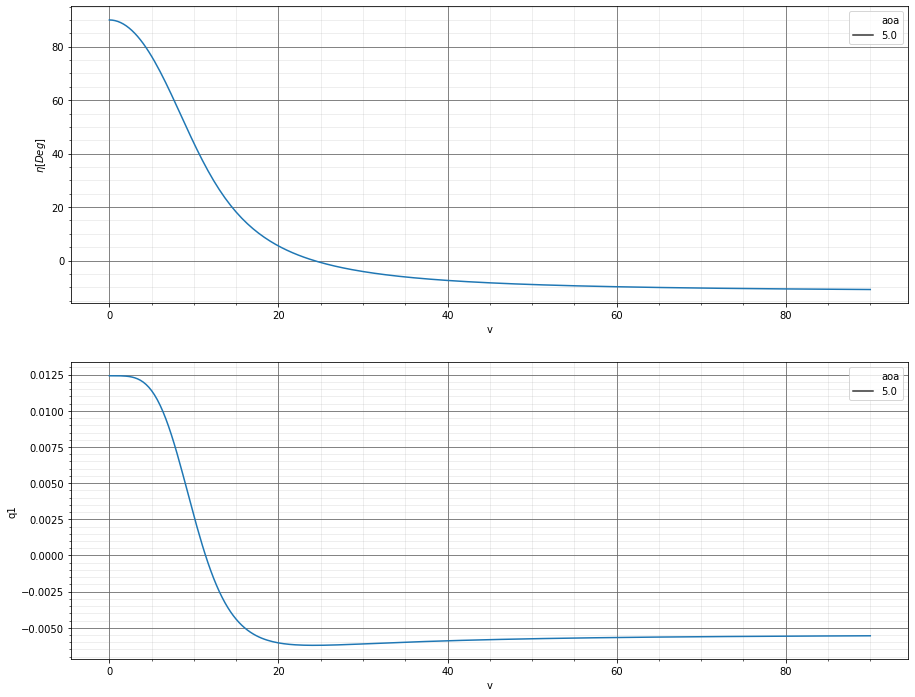

In [28]:
# plot the data
fig, axes = plt.subplots(2,1,figsize=(15,12))
df[r'$\eta [Deg]$']= np.rad2deg(df['eta'])
sns.lineplot(data=df,y=r'$\eta [Deg]$',x='v',style='aoa',ax=axes[0])

sns.lineplot(data=df,y='q1',x='v',style='aoa',ax=axes[1])

for ax in axes:
    #ax.set(xlim=(0,80))
    ax.grid(b=True, which='major', color='#666666', linestyle='-')
    ax.minorticks_on()
    ax.grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)

### Linearise the system about some fixed points

In [29]:
# create complete EoM

func = dof2.LinearEoM_func(sM,p,ignore=[p.V,p.sigma])

In [30]:
i=20
unique = []
p = [df['eta'].iloc[i],0,df['q1'].iloc[i],0]
evals,evecs = np.linalg.eig(func(df['v'].iloc[i],4,lp))
for idx,val in enumerate(evals):
    if np.conj(val) not in unique:
        unique.append(val)
        
np.conj(12j) not in unique     

True

In [31]:
data = df

flutdfv2 = pd.DataFrame()
for ratio in [2,4,8,16,32]:    
    for i in range(0,len(data)):  
        # get the fixed point
        lp = [data['eta'].iloc[i],0,data['q1'].iloc[i],0]
        # get the jacobian evaluated at this point
        j_lp = func(data['v'].iloc[i],ratio,lp)
        # get eigen value information
        jac_dat = dof2.ExtractEigenValueData(j_lp)
        # populate test specific data   
        jac_dat['V'] = data['v'].iloc[i]
        jac_dat['Mass Ratio'] = f'r = {ratio}'
        jac_dat['lp'] = [lp for i in range(0,len(jac_dat))]
        flutdfv2 = flutdfv2.append(jac_dat,sort=False)
        
flutdfv2 = flutdfv2.reset_index(drop=True)
flutdfv2   

,Mode,cn,Real,Imag,Frequency,Damping,Stable,Eigen Vector,V,Mass Ratio,lp
0,0,0.000000+3.571134j,0.000000e+00,3.571134,0.568364,6.123234e-17,True,"[-0.26965054643655956j, (0.9629582456194377+0j...",0.000000,r = 2,"[1.5707963267554577, 0, 0.012424503138314773, 0]"
1,1,0.000000+12.566371j,0.000000e+00,12.566371,2.000000,6.123234e-17,True,"[5.105130141179322e-12j, (-6.415295738859513e-...",0.000000,r = 2,"[1.5707963267554577, 0, 0.012424503138314773, 0]"
2,0,-0.024053+3.571094j,-2.405282e-02,3.571094,0.568370,-6.735268e-03,True,[(-0.0018161492444726305-0.26964155932534467j)...,0.333333,r = 2,"[1.5697194210903411, 0, 0.012424481095961839, 0]"
3,1,-0.000000+12.566373j,-6.295119e-09,12.566373,2.000000,-5.009497e-10,True,[(1.309930716827274e-07+0.00013939936490786525...,0.333333,r = 2,"[1.5697194210903411, 0, 0.012424481095961839, 0]"
4,0,-0.048106+3.570990j,-4.810566e-02,3.570990,0.568392,-1.347002e-02,True,"[(-0.0036320279682712947-0.2696134926047091j),...",0.666667,r = 2,"[1.5664889967613764, 0, 0.012424156951401833, 0]"
...,...,...,...,...,...,...,...,...,...,...,...
2705,1,0.060373+12.843271j,6.037253e-02,12.843271,2.044093,4.700661e-03,False,[(-0.030616009027176982-0.014404221939284416j)...,89.333333,r = 32,"[-0.18903291897006086, 0, -0.00555424140649926..."
2706,0,-6.675271+30.485838j,-6.675271e+00,30.485838,4.966924,-2.138955e-01,False,"[(-0.006849201702719665-0.03128017463156684j),...",89.666667,r = 32,"[-0.1891415393640759, 0, -0.005553494206767697..."
2707,1,0.060031+12.843161j,6.003144e-02,12.843161,2.044075,4.674144e-03,False,[(-0.030468414401732626-0.014307381754565198j)...,89.666667,r = 32,"[-0.1891415393640759, 0, -0.005553494206767697..."
2708,0,-6.699520+30.599855j,-6.699520e+00,30.599855,4.985475,-2.138736e-01,False,[(-0.0068230472873932425-0.03116406072662068j)...,90.000000,r = 32,"[-0.18924895068870826, 0, -0.00555275492581802..."


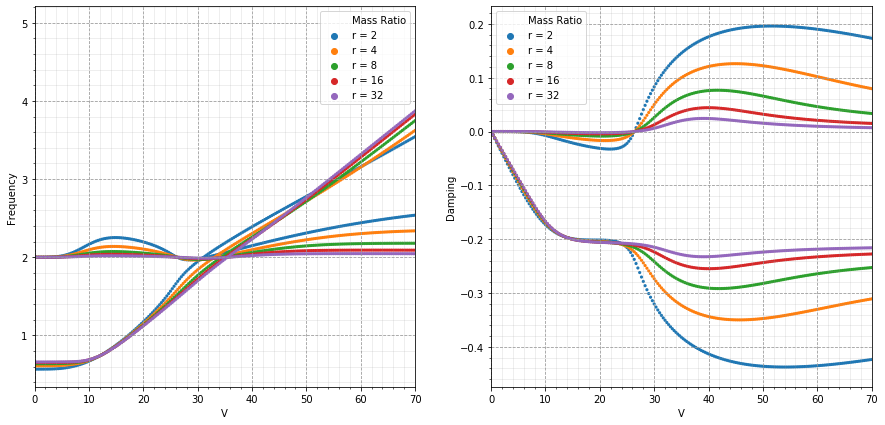

In [32]:
#data = flutdf[(flutdf['aoa']==5) & (flutdf['Damping']<0)]
data = flutdfv2[(flutdfv2['Stable'])]
data = flutdfv2
fig, axes = plt.subplots(1,2,figsize=(15,7))


sns.scatterplot(data=data,x='V',y='Frequency',hue='Mass Ratio',ax=axes[0],s=10,edgecolor = 'none')
sns.scatterplot(data=data,x='V',y='Damping',hue='Mass Ratio',ax=axes[1],s=10,edgecolor = 'none')
for i in [0,1]:
    #axes[i].set(xlim=(0,60))
    axes[i].grid(b=True, which='major', color='#999999', linestyle='--')
    axes[i].minorticks_on()
    axes[i].grid(b=True, which='minor', color='#999999', linestyle='-', alpha=0.2)
    axes[i].set(xlim=(0,70))

In [40]:
# get info for the first unstable point for each AoA

aoas = data['Mass Ratio'].unique()
idx = []

res = flutdfv2[(flutdfv2['V'].isin([0,20,26]))&(flutdfv2['Mass Ratio']=='r = 4')].copy()
#for i in data['Mass Ratio'].unique():
#    idx.append(data[data['Mass Ratio']==i].sort_values(by=['V'],axis=0).head(1).index[0])
    
#res = flutdfv2.iloc[idx].copy()
res['eta'] = res.apply(lambda row: np.rad2deg(row.lp[0]),axis=1)
res
res['ev'] = res.apply(lambda row: row['Eigen Vector'].round(2),axis=1)
res[['Mass Ratio','V','eta','Frequency','Damping','ev']] .round(2)


,Mass Ratio,V,eta,Frequency,Damping,ev
542,r = 4,0.0,90.00,0.61,-0.00,"[0.25j, (-0.97+0j), 0j, (-0-0j)]"
543,r = 4,0.0,90.00,2.00,0.00,"[0j, (-0+0j), (-0-0.08j), (1+0j)]"
662,r = 4,20.0,5.45,1.15,-0.20,"[(0.03+0.13j), (-0.99+0j), -0j, (0.03+0.01j)]"
663,r = 4,20.0,5.45,2.10,-0.02,"[0.07j, (-0.9+0j), (-0-0.03j), (0.43+0j)]"
698,r = 4,26.0,-1.58,1.56,-0.22,"[(0.02+0.1j), (-0.99+0j), -0.01j, (0.08+0.04j)]"
699,r = 4,26.0,-1.58,2.01,-0.00,"[(-0-0.07j), (0.94+0j), 0.03j, (-0.32+0.06j)]"


In [41]:
np.sin(np.deg2rad(1))